In [1]:
import os
from sqlalchemy import create_engine, text, bindparam
from sqlalchemy.engine import URL
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
import numpy as np
from sklearn import metrics
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import acf, pacf, adfuller

In [2]:
pip install pg8000

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 28.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
url = URL.create(
    "postgresql+pg8000",
    username=os.environ.get('DB_USER'),
    password=os.environ.get('DB_PASSWORD'),
    host=os.environ.get('DB_HOST'),
    database=os.environ.get('DB_NAME')
)

engine = create_engine(url)

In [4]:
with engine.connect() as conn:
    weather_station_coords = pd.read_sql(sql=text("SELECT DISTINCT latitude, longitude FROM weather_historical;"), con=conn)

In [5]:
with engine.connect() as conn:
    population_centers = pd.read_sql(sql=text("SELECT * FROM population_centers WHERE center_name IN ('boston', 'hartford');"), con=conn)   

In [6]:
weather_station_coords['type'] = "weather_station"
population_center_coords = population_centers[['latitude', 'longitude']]
population_center_coords['type'] = "population_center"
all_coords = pd.concat([population_center_coords, weather_station_coords], axis=0, ignore_index=True)

/tmp/ipykernel_1107/3508199798.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  population_center_coords['type'] = "population_center"


(-73.76439500000001, -67.507705, 40.85194, 47.59186)

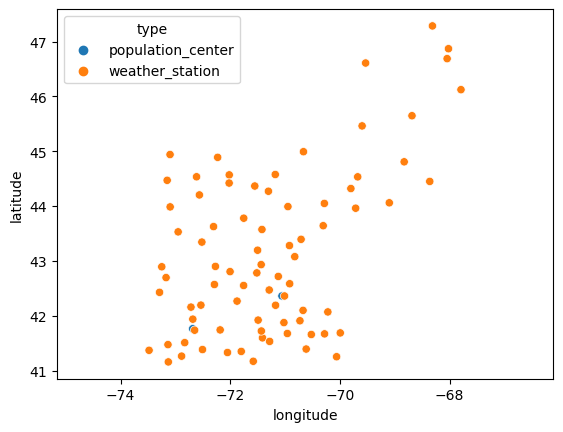

In [7]:
sns.scatterplot(all_coords, x='longitude', y='latitude', hue='type')
plt.axis('equal')

In [8]:
all_coords

,latitude,longitude,type
0,42.361145,-71.05708,population_center
1,41.763710,-72.68510,population_center
2,42.191200,-71.17330,weather_station
3,43.985500,-73.09550,weather_station
4,41.741900,-72.18360,weather_station
...,...,...,...
77,42.098200,-70.67210,weather_station
78,42.570100,-72.28860,weather_station
79,41.158300,-73.12890,weather_station
80,42.893500,-73.24860,weather_station


<Axes: xlabel='longitude', ylabel='latitude'>

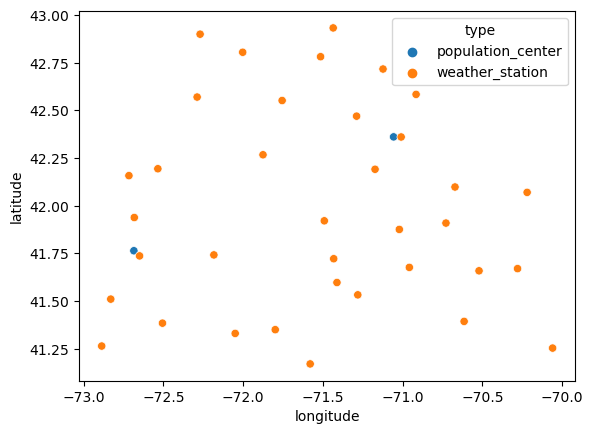

In [9]:
relevant_points = all_coords[(all_coords['latitude'].between(41, 43)) & (all_coords['longitude'].between(-73, -70))]
sns.scatterplot(relevant_points, x='longitude', y='latitude', hue='type')

In [10]:
c = cdist(relevant_points.loc[relevant_points['type'] == 'weather_station', ['longitude', 'latitude']], relevant_points.loc[relevant_points['type'] == 'population_center', ['longitude', 'latitude']], 'euclidean')
distances = pd.DataFrame(c, columns=['distance_to_boston', 'distance_to_hartford'])

In [11]:
distances

,distance_to_boston,distance_to_hartford
0,0.205884,1.571078
1,1.285501,0.501974
2,1.431485,0.769062
3,0.621658,1.551164
4,1.710384,0.044766
5,0.883491,2.166157
6,0.685669,1.711073
7,1.747595,0.419962
8,1.490414,2.674004
9,0.724291,1.218541


(-0.05692527596842474,
 2.2378597520050385,
 -0.08669548755736906,
 2.8054659234720445)

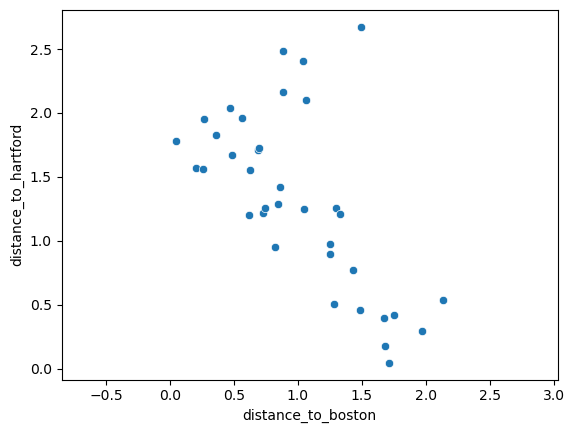

In [12]:
g = sns.scatterplot(distances, x='distance_to_boston', y='distance_to_hartford')
plt.axis('equal')

In [13]:
X = distances.to_numpy()

In [14]:
distortions = []
inertias = []
silhouettes = []
mapping1 = {}
mapping2 = {}
mapping3 = {}
labels = {}

cluster_amount = range(2, 15)
for n in cluster_amount:
    kmeans = KMeans(n_clusters=n, n_init=10)
    kmeans.fit(X)
    silhouettes.append(metrics.silhouette_score(X, kmeans.labels_, metric='euclidean'))
    distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeans.inertia_)
    mapping1[n] = sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]
    mapping2[n] = kmeans.inertia_
    mapping3[n] = metrics.silhouette_score(X, kmeans.labels_, metric='euclidean')
    labels[n] = kmeans.labels_

<Axes: >

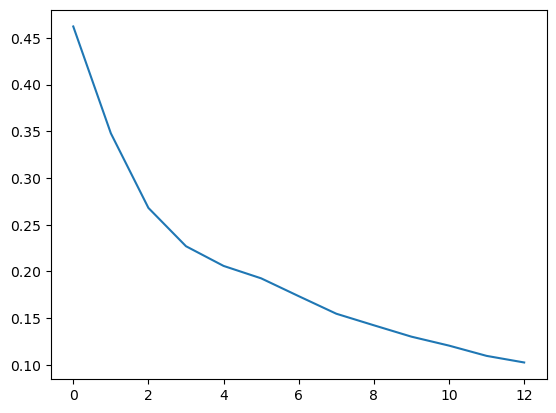

In [15]:
sns.lineplot(distortions)

<Axes: >

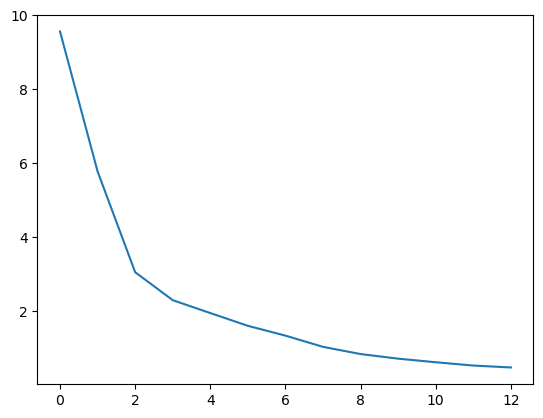

In [16]:
sns.lineplot(inertias)

<Axes: >

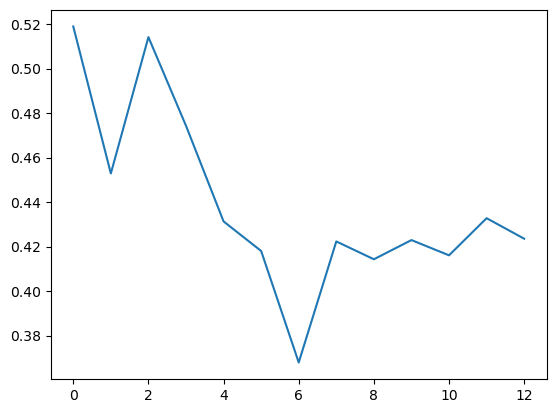

In [17]:
sns.lineplot(silhouettes)

In [18]:
labels[2]

array([0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0], dtype=int32)

In [19]:
relevant_points['label'] = 'population_center'
relevant_points.loc[2:, 'label'] = labels[2]
relevant_points

/tmp/ipykernel_1107/1591246521.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_points['label'] = 'population_center'


,latitude,longitude,type,label
0,42.361145,-71.05708,population_center,population_center
1,41.763710,-72.68510,population_center,population_center
2,42.191200,-71.17330,weather_station,0
4,41.741900,-72.18360,weather_station,1
7,41.330000,-72.05000,weather_station,1
8,42.781800,-71.51480,weather_station,0
9,41.736700,-72.64940,weather_station,1
10,41.658500,-70.52150,weather_station,0
11,42.932800,-71.43570,weather_station,0
15,41.383900,-72.50590,weather_station,1


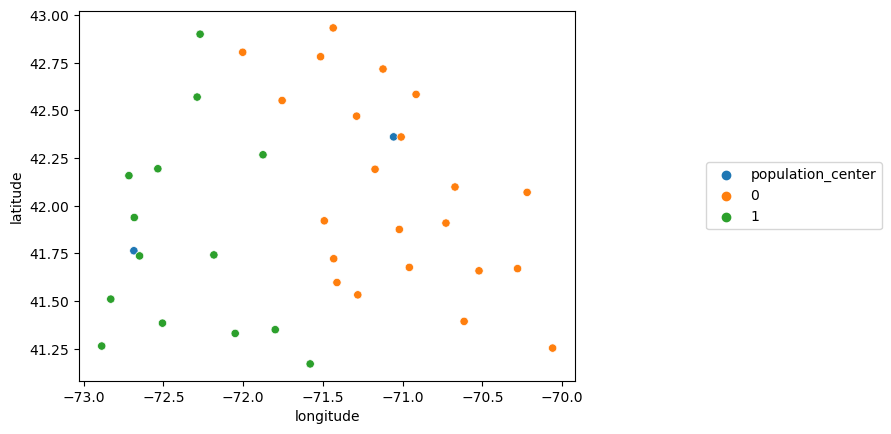

In [20]:
g = sns.scatterplot(relevant_points, x='longitude', y='latitude', hue='label')
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

In [21]:
hartford_area = tuple(relevant_points.loc[relevant_points['label'] == 1, ['latitude', 'longitude']].itertuples(index=False, name=None))
boston_area = tuple(relevant_points.loc[relevant_points['label'] == 0, ['latitude', 'longitude']].itertuples(index=False, name=None))
params = [boston_area, hartford_area]

In [22]:
dfs = dict()

for i, param in enumerate(params):
    placeholders = ", ".join("(latitude, longitude)" for _ in param)
    stmt = '''SELECT 
        weather_datetime, 
        AVG(NULLIF(apparent_temperature, 'NaN')) apparent_temperature_avg, 
        AVG(NULLIF(air_temperature, 'NaN')) air_temperature_avg, 
        AVG(NULLIF(dewpoint_temperature, 'NaN')) dewpoint_temperature_avg,
        AVG(NULLIF(relative_humidity, 'NaN')) relative_humidity_avg,
        AVG(NULLIF(total_precipitation, 'NaN')) total_precipitation_avg, 
        AVG(NULLIF(wind_speed, 'NaN')) wind_speed_avg
        FROM weather_historical
        WHERE (latitude, longitude) IN ({})
        GROUP BY weather_datetime
        ORDER BY weather_datetime ASC;'''.format(placeholders)
    with engine.connect() as conn:
        dfs[i] = pd.read_sql(sql=text(stmt), params=(*param,) , con=conn)

In [23]:
with engine.connect() as conn:
    load_historical = pd.read_sql(sql=text("SELECT load_datetime, load_mw FROM grid_load;"), con=conn)

In [24]:
stmt = """SELECT gf.forecasted_at, gf.forecasted_for, gf.load_mw FROM grid_forecast gf 
INNER JOIN (SELECT MAX(forecasted_at) MaxDate, forecasted_for FROM grid_forecast group by forecasted_for) tm
ON tm.forecasted_for = gf.forecasted_for AND gf.forecasted_at = tm.MaxDate;"""
with engine.connect() as conn:
    load_forecast = pd.read_sql(sql=text(stmt), con=conn)

In [25]:
boston_area_weather = dfs[0].rename(columns={c:'boston_area_'+c for c in dfs[0].columns if c not in ['weather_datetime']})
hartford_area_weather = dfs[1].rename(columns={c:'hartford_area_'+c for c in dfs[1].columns if c not in ['weather_datetime']})

In [26]:
two_cluster_weather = boston_area_weather.merge(hartford_area_weather, on='weather_datetime', how='outer')

In [29]:
#two_cluster_weather = pd.read_csv('/home/jovyan/work/historic_weather_two_clusters.csv', index_col=0)
two_cluster_weather['weather_datetime'] = two_cluster_weather['weather_datetime'].astype('datetime64')

/tmp/ipykernel_1107/3797170091.py:2: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  two_cluster_weather['weather_datetime'] = two_cluster_weather['weather_datetime'].astype('datetime64')


In [30]:
load_historical = load_historical.drop_duplicates()

In [31]:
d = (
    two_cluster_weather
    .merge(
        load_historical, 
        left_on='weather_datetime', 
        right_on='load_datetime', 
        how='inner', indicator=True)
    .drop(columns=['_merge', 'weather_datetime'])
)

In [42]:
result = adfuller(d['load_mw'])
print(result[0], result[1])

-10.895011860275984 1.1983625588869324e-19


In [42]:
d.to_csv("work/New-England-Load-Forecasting/analysis/actual_clean_data.csv")

In [35]:
os.getcwd()

'/home/jovyan'

In [3]:
data = pd.read_csv('/home/jovyan/work/clean_data.csv', index_col=0)
data

,boston_area_apparent_temperature_avg,boston_area_air_temperature_avg,boston_area_dewpoint_temperature_avg,boston_area_relative_humidity_avg,boston_area_total_precipitation_avg,boston_area_wind_speed_avg,hartford_area_apparent_temperature_avg,hartford_area_air_temperature_avg,hartford_area_dewpoint_temperature_avg,hartford_area_relative_humidity_avg,hartford_area_total_precipitation_avg,hartford_area_wind_speed_avg,load_mw
load_datetime,,,,,,,,,,,,,
2019-01-01 01:00:00,30.284211,35.628461,30.891282,83.127307,0.733077,7.660000,30.284211,35.628461,30.891282,83.127307,0.733077,7.660000,11496.656
2019-01-01 02:00:00,29.285714,35.365063,31.667595,86.571772,1.548987,8.799351,29.285714,35.365063,31.667595,86.571772,1.548987,8.799351,11368.765
2019-01-01 03:00:00,28.728421,35.390769,32.420769,89.070000,2.337949,9.719342,28.728421,35.390769,32.420769,89.070000,2.337949,9.719342,11270.259
2019-01-01 04:00:00,29.151948,35.561139,33.070253,90.861012,2.822911,9.726494,29.151948,35.561139,33.070253,90.861012,2.822911,9.726494,11309.606
2019-01-01 05:00:00,29.258684,35.818333,33.696154,92.155512,3.821282,10.464342,29.258684,35.818333,33.696154,92.155512,3.821282,10.464342,11516.118
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-12 19:00:00,40.403636,43.719747,23.707342,46.276962,0.000000,6.043766,40.403636,43.719747,23.707342,46.276962,0.000000,6.043766,14278.498
2023-03-12 20:00:00,40.736753,44.012278,23.570000,45.724810,0.000000,5.881818,40.736753,44.012278,23.570000,45.724810,0.000000,5.881818,13940.147
2023-03-12 21:00:00,39.977051,43.558101,23.632152,46.793418,0.000000,6.291795,39.977051,43.558101,23.632152,46.793418,0.000000,6.291795,13259.199


In [4]:
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend() 
    
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(data['load_mw'],'raw data')

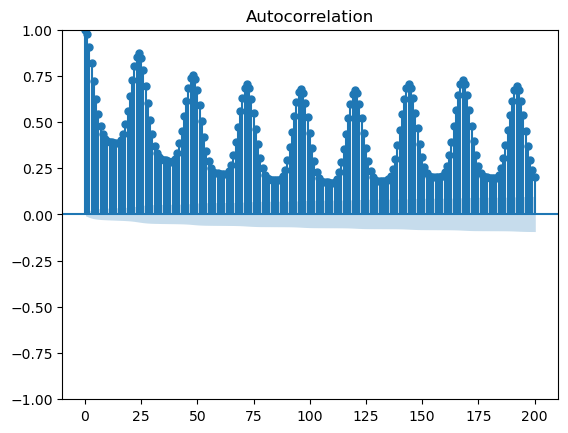

In [34]:
plot_acf(data['load_mw'], lags=200)
plt.show()

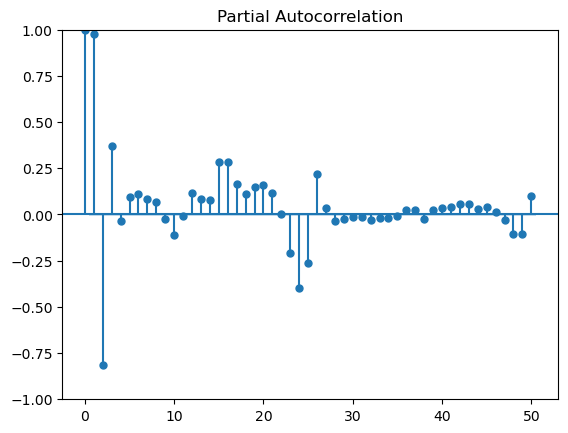

In [35]:
plot_pacf(data['load_mw'], lags=50)
plt.show()

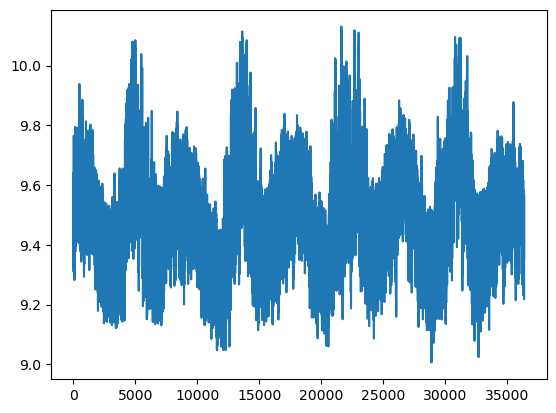

In [26]:
plt.plot(np.log(data['load_mw']))

In [51]:
exog_cols = [c for c in d.columns if c not in ['load_datetime', 'load_mw']]
d = d.set_index('load_datetime')

In [14]:
plot_pacf(d['load_mw'])

In [53]:
d.plot('load_mw')

In [122]:


model = SARIMAX(
    endog = d['load_mw'].tonumpy(),
    exo = d[exog_cols].tonumpy(),
)

,boston_area_apparent_temperature_avg,boston_area_air_temperature_avg,boston_area_dewpoint_temperature_avg,boston_area_relative_humidity_avg,boston_area_total_precipitation_avg,boston_area_wind_speed_avg,hartford_area_apparent_temperature_avg,hartford_area_air_temperature_avg,hartford_area_dewpoint_temperature_avg,hartford_area_relative_humidity_avg,hartford_area_total_precipitation_avg,hartford_area_wind_speed_avg,load_datetime,load_mw
0,30.284211,35.628461,30.891282,83.127307,0.733077,7.660000,30.284211,35.628461,30.891282,83.127307,0.733077,7.660000,2019-01-01 01:00:00,11496.656
1,29.285714,35.365063,31.667595,86.571772,1.548987,8.799351,29.285714,35.365063,31.667595,86.571772,1.548987,8.799351,2019-01-01 02:00:00,11368.765
2,28.728421,35.390769,32.420769,89.070000,2.337949,9.719342,28.728421,35.390769,32.420769,89.070000,2.337949,9.719342,2019-01-01 03:00:00,11270.259
3,29.151948,35.561139,33.070253,90.861012,2.822911,9.726494,29.151948,35.561139,33.070253,90.861012,2.822911,9.726494,2019-01-01 04:00:00,11309.606
4,29.258684,35.818333,33.696154,92.155512,3.821282,10.464342,29.258684,35.818333,33.696154,92.155512,3.821282,10.464342,2019-01-01 05:00:00,11516.118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36761,40.403636,43.719747,23.707342,46.276962,0.000000,6.043766,40.403636,43.719747,23.707342,46.276962,0.000000,6.043766,2023-03-12 19:00:00,14278.498
36762,40.736753,44.012278,23.570000,45.724810,0.000000,5.881818,40.736753,44.012278,23.570000,45.724810,0.000000,5.881818,2023-03-12 20:00:00,13940.147
36763,39.977051,43.558101,23.632152,46.793418,0.000000,6.291795,39.977051,43.558101,23.632152,46.793418,0.000000,6.291795,2023-03-12 21:00:00,13259.199
36764,38.114872,41.935823,24.234937,50.867468,0.000000,6.199487,38.114872,41.935823,24.234937,50.867468,0.000000,6.199487,2023-03-12 22:00:00,12343.839
